This Colab reproduces the figures from *Revisiting the Calibration of Modern Neural Networks*.

See paper at https://arxiv.org/abs/2106.07998

See code at https://github.com/google-research/robustness_metrics/

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Setup

In [ ]:
# After executing this cell for the first time, please restart the Colab runtime
# so that the installed dependencies can be imported
# (Runtime --> Restart Runtime).
!pip install --no-deps "git+https://github.com/google-research/robustness_metrics.git#egg=robustness_metrics"
!pip install "matplotlib>=3.3"

In [ ]:
import os

import matplotlib as mpl
import pandas as pd
import tensorflow as tf

from robustness_metrics.projects.revisiting_calibration import display
from robustness_metrics.projects.revisiting_calibration import figures
from robustness_metrics.projects.revisiting_calibration import plotting

assert not mpl.__version__.startswith('3.2'), (
    "Please restart the Colab runtime (Runtime --> Restart Runtime) to load "
    "the version of Matplotlib that was installed with pip above. Version "
    "3.3 or greater is needed."
)

plotting.set_seaborn_theme()
# Makes sure figures appear large enough.
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 150

In [ ]:
# Load data:
DATASET_DIR = 'gs://gresearch/revisiting-calibration'

with tf.io.gfile.GFile(os.path.join(DATASET_DIR, "df_main_2021_06_15.zip"), "rb") as f:
  df_main = pd.read_csv(f, index_col="index", compression="zip")

with tf.io.gfile.GFile(os.path.join(DATASET_DIR, "df_reliability_2021_06_15.zip"), "rb") as f:
  df_reliability = pd.read_csv(f, index_col="index", compression="zip")

# Dataset structure

**`df_main`** contains our dataset of calibration and accuracy measurements. Each row contains a single combination of model, evaluation dataset, and evaluation metric. The dataset has the following columns:

* **`ModelFamily`**: The model family, as used in the paper.

* **`ModelName`**: Name of the model variant. Please refer to the paper for model details.

* **`DatasetName`**: Name of the evaluation dataset, as used in [TFDS](https://www.tensorflow.org/datasets).

* **`Metric`**: Name of the metric as specified in [`robustness_metrics/metrics`](https://github.com/google-research/robustness_metrics/tree/master/robustness_metrics/metrics). For example, `gce` refers to the [General Calibration Error](https://github.com/google-research/robustness_metrics/blob/6c9dda9e23d7ad9cfdffef7421bf07296b8960e6/robustness_metrics/metrics/uncertainty.py#L689). Some metrics, such as `gce`, have parameters in their name. These correspond to the parameters in the [code](https://github.com/google-research/robustness_metrics/blob/6c9dda9e23d7ad9cfdffef7421bf07296b8960e6/robustness_metrics/metrics/uncertainty.py#L689).

* **`MetricKey`**: The dict key of the stored Metric as specified in the code (e.g. [here](https://github.com/google-research/robustness_metrics/blob/6c9dda9e23d7ad9cfdffef7421bf07296b8960e6/robustness_metrics/metrics/uncertainty.py#L872). Most metrics only have one key that is identical to the metric name.

* **`MetricValue`**: The value of the metric.

* **`use_dataset_labelset`**: For datasets that use a subset of the standard 1000 ImageNet classes, if `use_dataset_labelset` is True, the predicted probabilities corresponding to classes that are not in the dataset will be removed and the others scaled to sum up to one ([code](https://github.com/google-research/robustness_metrics/blob/6c9dda9e23d7ad9cfdffef7421bf07296b8960e6/robustness_metrics/metrics/uncertainty.py#L800-L802)).

* **`rescaling_method`**: Method used for post-hoc rescaling of predictions, either "none" or "temperature_scaling".

* **`rescaling_kwargs`**: Keyword arguments to the rescaling method as defined in [`models/rescaling.py`](https://github.com/google-research/robustness_metrics/blob/master/robustness_metrics/models/rescaling.py).

* **`imagenet_error`**: For convenience, this column contains the classification error on clean ImageNet for this row's model.

* **`downstream_error`**: For convenience, this column contains the classification error of this row's model on this row's dataset.

* **`brier`**: For convenience, this column contains the Brier score of this row's model on this row's dataset.

* **`nll`**: For convenience, this column contains the negative log likelihood of this row's model on this row's dataset.

* **`tau_on_eval_data`**: The optimal temperature factor on the *evaluation* dataset, i.e. the dataset specified in the given row. Note that this is different from the temperature factor used for post-hoc recalibration, which is always computed on a held-out part of clean ImageNet (specifically, `imagenet(split='validation[:20%]')`), rather than the evaluation dataset.

* **`corruption_type`**: If the dataset is ImageNet-C, this column contains the corruption type.

* **`severity`**: If the dataset is ImageNet-C, this column contains the corruption severity.

* **`RawModelName`**: Model name including post-hoc rescaling information.

In [ ]:
# @title Examle rows
df_main.head(5)

,ModelFamily,ModelName,DatasetName,Metric,MetricKey,MetricValue,use_dataset_labelset,rescaling_method,rescaling_kwargs,imagenet_error,downstream_error,brier,nll,tau_on_eval_data,corruption_type,severity,RawModelName
index,,,,,,,,,,,,,,,,,
0,alexnet,alexnet,imagenet(split='validation[20%:]'),accuracy,accuracy,0.561275,NaN,none,{},0.438725,0.438725,0.56209,1.923671,1.096196,NaN,NaN,alexnet+none()
1,alexnet,alexnet,imagenet(split='validation[20%:]'),brier,brier,0.562090,NaN,none,{},0.438725,0.438725,0.56209,1.923671,1.096196,NaN,NaN,alexnet+none()
2,alexnet,alexnet,imagenet(split='validation[20%:]'),"gce(binning_scheme='adaptive',max_prob=True,cl...",gce,0.030830,NaN,none,{},0.438725,0.438725,0.56209,1.923671,1.096196,NaN,NaN,alexnet+none()
3,alexnet,alexnet,imagenet(split='validation[20%:]'),"gce(binning_scheme='adaptive',max_prob=True,cl...",gce,0.028780,NaN,none,{},0.438725,0.438725,0.56209,1.923671,1.096196,NaN,NaN,alexnet+none()
4,alexnet,alexnet,imagenet(split='validation[20%:]'),"gce(binning_scheme='adaptive',max_prob=True,cl...",gce,0.037526,NaN,none,{},0.438725,0.438725,0.56209,1.923671,1.096196,NaN,NaN,alexnet+none()


In [ ]:
# @title Dataset stats
print(f'Number of model families: {df_main.ModelFamily.nunique()}')
print(f'Number of models: {df_main.ModelName.nunique()}')
print(f'Number of datasets: {df_main.DatasetName.nunique()}')
print(f'Number of metric variants: {df_main.Metric.nunique()}')

Number of model families: 16
Number of models: 185
Number of datasets: 79
Number of metric variants: 28


In addition to the main dataframe, **`df_reliability`** provides reliability diagram statistics for many of the models. `df_reliability` has the following columns:

* **`RawModelName`**: As in `df_main`.
* **`DatasetName`**: As in `df_main`.
* **`num_bins`**: Number of bins used for reliability diagram statistics.
* **`adaptive`**: If `True`, adaptive (equal mass) binning was used. If `False`, even (equal width) binning was used.
* **`conf_k`**: Mean model confidence (predicted score) in bin $k$.
* **`acc_k`**:  Mean accuracy in bin $k$.
* **`edge_k`**: Upper edge of bin $k$.
* **`count_k`**: Number of samples in bin $k$.

In [ ]:
# @title `df_reliability` example rows
df_reliability.head(5)

,num_bins,adaptive,RawModelName,DatasetName,conf_0,acc_0,edge_0,count_0,conf_1,acc_1,edge_1,count_1,conf_2,acc_2,edge_2,count_2,conf_3,acc_3,edge_3,count_3,conf_4,acc_4,edge_4,count_4,conf_5,acc_5,edge_5,count_5,conf_6,acc_6,edge_6,count_6,conf_7,acc_7,edge_7,count_7,conf_8,acc_8,edge_8,count_8,conf_9,acc_9,edge_9,count_9
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10,False,efficientnet-b4-label_smoothing=0.03+none(),imagenet_a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,False,wsl_32x32d+temperature_scaling(beta=0.82088172...,imagenet_r,0.069525,0.128011,0.1,1453.0,0.146143,0.257304,0.2,1951.0,0.246903,0.379737,0.3,1293.0,0.350105,0.470948,0.4,981.0,0.451485,0.573375,0.5,954.0,0.549324,0.631466,0.6,928.0,0.652237,0.722437,0.7,1034.0,0.751147,0.777385,0.8,1132.0,0.855222,0.851335,0.9,1648.0,0.987244,0.973156,1.0,18626.0
2,10,False,imagenet21k-r101-x3-size=2600000-steps=457032+...,imagenet(split='validation[20%:]'),0.083989,0.078947,0.1,38.0,0.161306,0.129213,0.2,356.0,0.255086,0.269896,0.3,867.0,0.354501,0.326748,0.4,1316.0,0.452144,0.413158,0.5,1900.0,0.550420,0.505129,0.6,2437.0,0.651188,0.585977,0.7,2396.0,0.751976,0.651061,0.8,2734.0,0.854616,0.783723,0.9,4018.0,0.978908,0.951166,1.0,23938.0
3,10,False,jft-r101-x3-size=5200000-steps=1120000+tempera...,imagenet_r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,False,efficientnet-noisy-student-b5+temperature_scal...,imagenet_v2(variant='MATCHED_FREQUENCY'),0.091884,0.142857,0.1,7.0,0.160914,0.103448,0.2,29.0,0.256441,0.140496,0.3,121.0,0.352702,0.235043,0.4,234.0,0.454274,0.368687,0.5,396.0,0.549118,0.415020,0.6,506.0,0.651228,0.477444,0.7,532.0,0.752222,0.589198,0.8,611.0,0.856336,0.700457,0.9,1095.0,0.963277,0.916525,1.0,6469.0


# Main figures

Please refer to the [source code](https://github.com/google-research/robustness_metrics/blob/master/robustness_metrics/projects/revisiting_calibration/figures) for analysis details and plotting options.

## Figure 1: In-distribution calibration

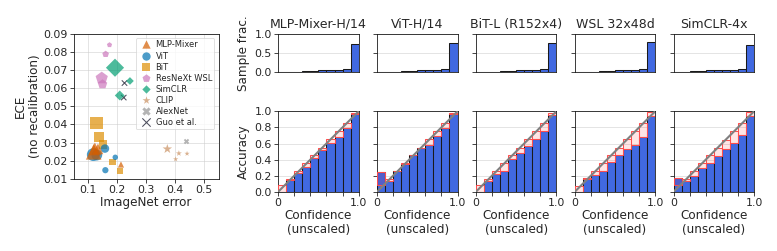

In [ ]:
fig = figures.clean_imagenet_and_reliability_diags.plot(
    df_main, df_reliability, rescaling_method='none', add_guo=True)

## Figure 2: In-distribution calibration + temperature scaling

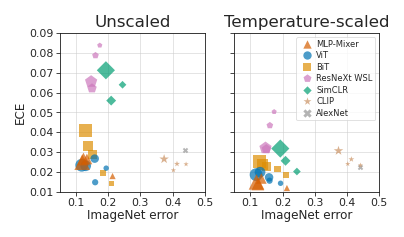

In [ ]:
fig = figures.clean_imagenet_temp_scaling.plot(df_main)

## Figure 3: The effect of pretraining dataset

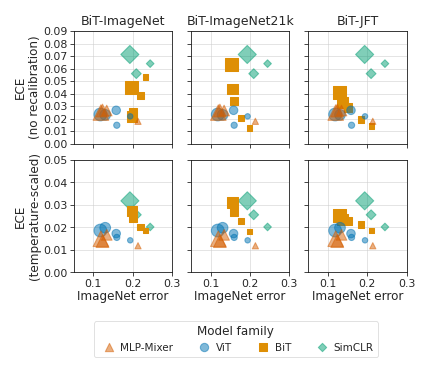

In [ ]:
fig = figures.clean_imagenet_temp_scaling_bit_pretrain_comparison.plot(df_main)

## Figure 4: ImageNet-C

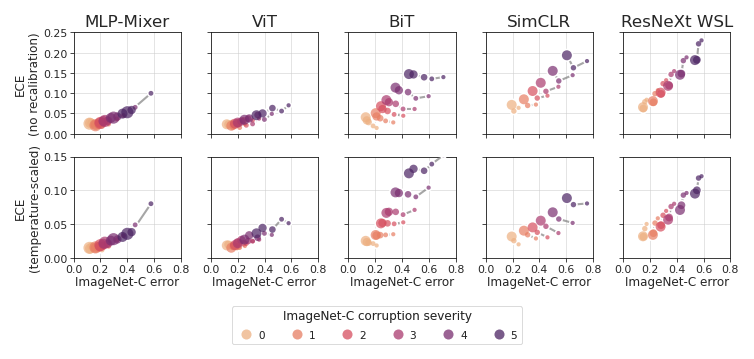

In [ ]:
fig = figures.imagenet_c.plot(df_main)

## Figure 5: Model size vs. robustness to distribution shift

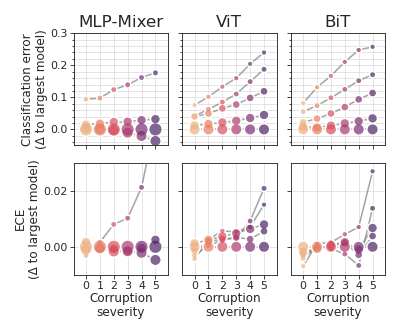

In [ ]:
g = figures.imagenet_c.plot_error_increase_vs_model_size(
    df_main, compact_layout=True)

## Figure 6: Other out-of-distribution datasets

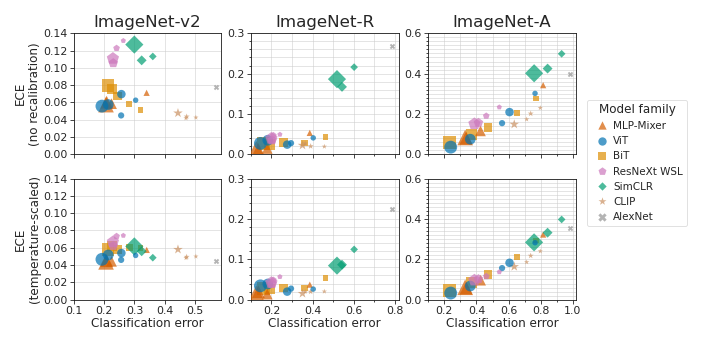

In [ ]:
g = figures.ood_comparison.plot(df_main)

## Figure 8: ECE bias

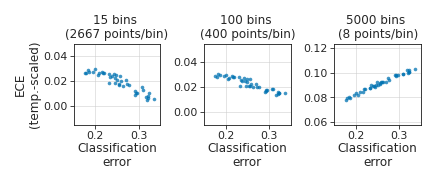

In [ ]:
g = figures.ece_bias.plot(df_main)

# Supplementary figures

## Figure 9: Fine-grained pretraining analysis

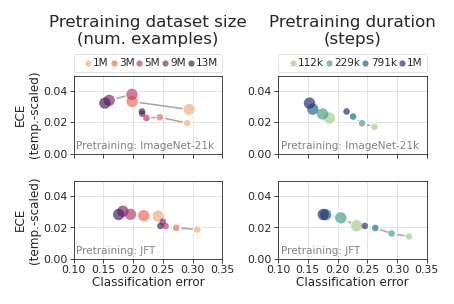

In [ ]:
g = figures.pretrain_size_steps_sweep.plot(
    df_main, upstream_datasets=['imagenet21k', 'jft'])

## Figure 10: Correlation between calibration and accuracy

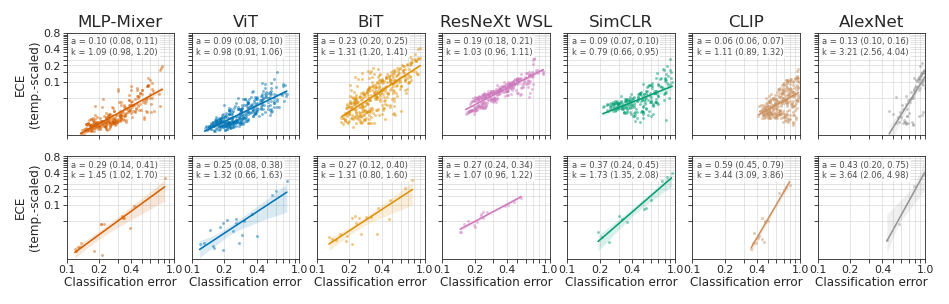

In [ ]:
family_order = display.get_model_families_sorted()
fig = figures.acc_calib_regression.plot(df_main, family_order)

## ECE variants

The ECE variant is configurable for all figures by specifying `gce_prefix`. See `df_main.Metric` for available options. For examle:

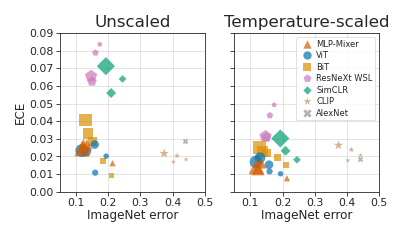

In [ ]:
num_bins = 15
binning_scheme = 'even'

gce_prefix = (f"gce(binning_scheme={binning_scheme!r},max_prob=True,"
              f"class_conditional=False,norm='l1',num_bins={num_bins},"
              "threshold=0.0")

fig = figures.clean_imagenet_temp_scaling.plot(
    df_main, gce_prefix=gce_prefix)

for ax in fig.axes:
  ax.set_ylim(bottom=0.0)

## Alternative calibration metrics

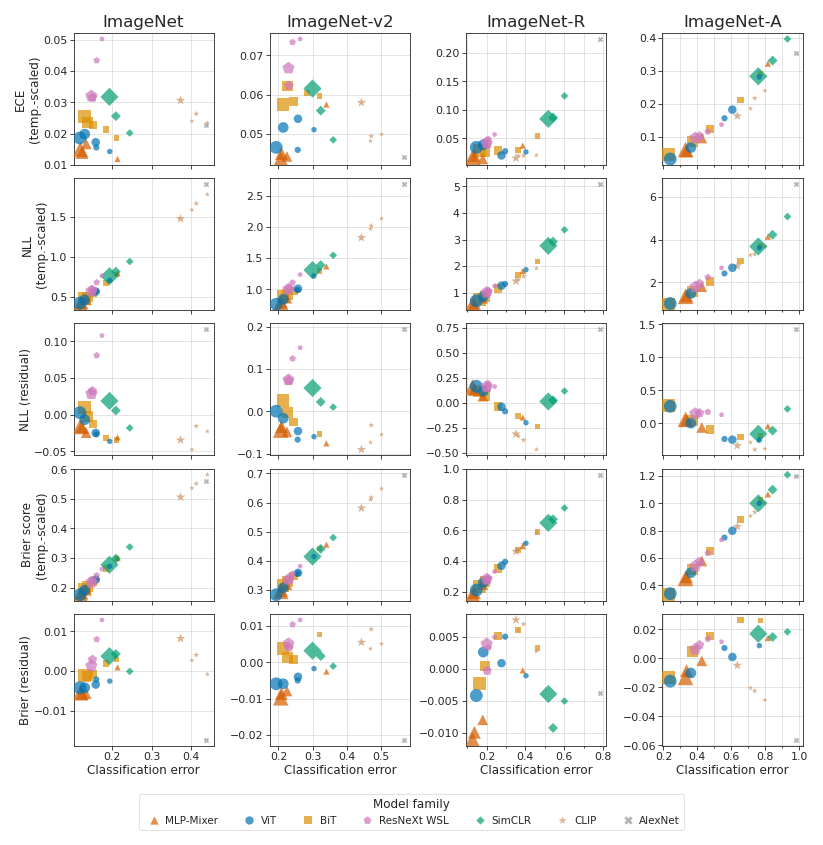

In [ ]:
g = figures.ood_comparison.plot_alternative_metrics(
    df_main,
    xs=['downstream_error', 'downstream_error', 'downstream_error', 'downstream_error', 'downstream_error'],
    ys=['MetricValue', 'nll', 'nll_residual', 'brier', 'brier_residual'])

## Reliability diagrams

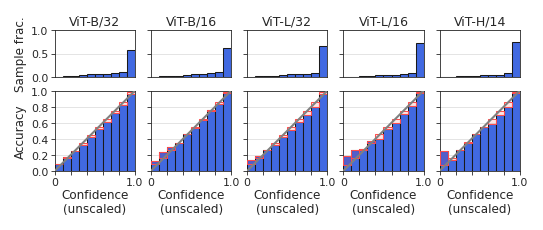

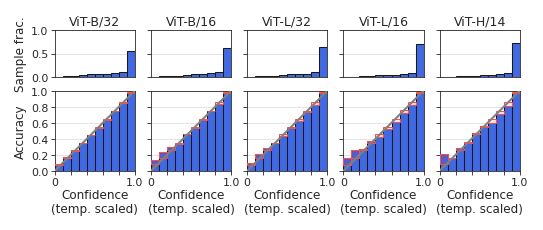

In [ ]:
for family in ['vit']:
    for rescaling_method in ['none', 'temperature_scaling']:
      fig = figures.clean_imagenet_and_reliability_diags.plot_reliability_diagrams(
          df_main, df_reliability, family=family, rescaling_method=rescaling_method)